In [1]:
# All the necesssary imports.
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from keras.layers.core import Activation, Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Load in the data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize to [-1, 1]
print(y_train)
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

# For the sake of time don't work with the entire dataset.
x_train = x_train[:20000]
y_train = y_train[:20000]
y_train_cat = to_categorical(y_train, num_classes=20)
y_test_cat = to_categorical(y_test, num_classes=20)
print(y_train)
print (x_train[0].shape)
print(y_train_cat.shape)
print(y_train.shape)
print (y_test_cat.shape)
# Flatten the data.
# x_train = x_train.reshape((-1, 784))
# x_test = x_test.reshape((-1, 784))

[5 0 4 ..., 5 6 8]
[5 0 4 ..., 1 4 2]
(28, 28)
(20000, 20)
(20000,)
(10000, 20)


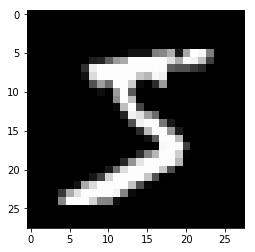

[5 0 4 ..., 1 4 2]


In [3]:
# Plot out a sample image (reshaped to 28 x 28)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.show()
print(y_train)

In [4]:
# How many noise dimensions our generator should take in
NOISE_DIM = 20 # Changed to 20 because of the twenty possible digits (1 real, 1 fake, 2 real, 2 fake ...)

# Define the generator here.
# The generator should have the following layers.
# Fully connected from # noise dimensions to 256
# LeakyReLU
# Fully connected from 256 to 512
# LeakyReLU
# Fully connected from 512 to 1024
# LeakyReLU
# Fully connected from 1024 to 784 (28*28)
# tanh (To normalize our output from -1 to 1)

def generator():
    model = Sequential()
    
    # How to add leaky relu
    #model.add(LeakyReLU())
    model.add(Dense(256, input_shape=(NOISE_DIM,), ))
    model.add(LeakyReLU())
    model.add(Dropout(.3))
    
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dropout(.3))
    
    model.add(Dense(1024))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Dense(784))
    model.add(Activation('tanh'))
    
    model.add(Reshape((28, 28, -1)))
    return model

In [5]:
#Random number between 0 and top
def rand(top):
    return np.random.randint(low=0, high=top)
    

In [6]:
# Define the discriminator here.
# Should have the following layers
# Fully connected from 784 (28*28) to 1024 0
# LeakyReLU 0
# Dropout with p = 0.3 0
# Fully connected from 1024 to 512 0
# LeakyReLU 0
# Dropout with p = 0.3 0
# Fully connected from 512 to 256 0
# LeakyReLU
# Dropout with p = 0.3
# Fully connected from 256 to 1
# sigmoid (to get our probability)

def discriminator():
    model = Sequential()
    #model.add(Dense(784), input_dim=784)
    model.add(Conv2D(128, input_shape= (28, 28, 1), kernel_size=3,data_format='channels_last'))
    #kernel_initializer=initializers.RandomNormal(stddev=0.02),
                    
    model.add(LeakyReLU())
    
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=3))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, kernel_size=2))
    model.add(LeakyReLU())
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(1, activation='sigmoid')) 
    
    return model

In [7]:
# Feed the generated image into the discriminator. 

def combine(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [8]:
#Make so that model learns how to write individual digits as well (0-9)
def digitRecognizer():
    model = Sequential()
    model.add(Conv2D(input_shape = [28, 28, 1], filters = 128, kernel_size=3, 
                activation='relu', data_format="channels_last"))
    model.add(Conv2D(filters = 128, kernel_size=3,
                activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters = 64, kernel_size=2,
                activation='relu'))
    model.add(Conv2D(filters = 64, kernel_size=2,
                activation='relu'))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(20, activation='softmax')) 
    
    return model

In [9]:
# Compile the discriminator, generator, and full GAN. 
# Probably use Adam optimizer...
# 
optimizer = Adam(lr=0.0002, beta_1=0.5)
loss = 'binary_crossentropy'

# Discriminator
d = discriminator()
d.compile(loss=loss, optimizer=optimizer)

# Generator
g = generator()
g.compile(loss=loss, optimizer=optimizer)

# Full gan
gd = combine(g, d)
gd.compile(loss=loss, optimizer=optimizer)

digit = digitRecognizer()
digit.compile(loss='categorical_crossentropy', optimizer='RMSProp')

print("Discriminator Summary: ")
d.summary()
print("")

print("Generator Sumamry: ")
g.summary()
print("")

print("DigitRecognizer Summary: ")
digit.summary()
gdigit = combine(g, digit)
gdigit.compile(loss=loss, optimizer='RMSProp')


Discriminator Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 26, 26, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)    

In [10]:
#This function is very important for the model, higher levels of noise means that the digits will appear more unique
#But will probably also look worse
def get_noise(batch_size, NOISE_DIM):
    noise = np.random.uniform(0, .005, size=(batch_size, NOISE_DIM))
    for i in range(len(noise)):
        #Random number between 0 and 9
        index = rand(9)
        noise[i][index] += .995
    return noise

In [11]:
# Helper function to display sample from the network
def disp_sample(g):
    #Put noise between 0 and .5 so that not very likely to be most digits, with one above this amount
    noise = get_noise(batch_size, NOISE_DIM)    
    generated_images = g.predict(noise, verbose=0)
    
    for pic in range(4):
        for num in range(len(noise[pic])):
            if noise[pic][num] > .6: #.6 was arbitrarily chosen
                print ("Supposed to be " + str(num))
        #Print what it's 'supposed' to look like
        plt.imshow(generated_images[pic].reshape((28, 28)), cmap=plt.get_cmap('gray'))
        plt.show()

In [12]:
#Function takes noise and returns the y_vals for the generated image (i.e. 10 + whatever their value should be)
def target_y(y_vals):
    copy = y_vals
    for i in range(len(copy)):
        copy[i] += 10
    return to_categorical(copy, num_classes=20)
    

[5 0 4 ..., 1 4 2]
Starting regression...
Epoch #0
Supposed to be 3


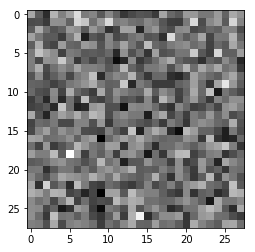

Supposed to be 1


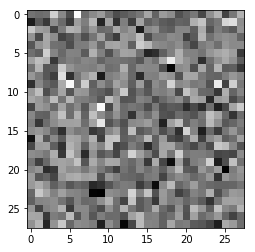

Supposed to be 6


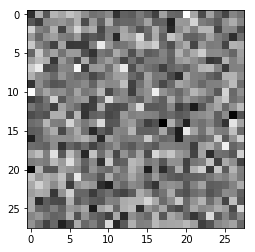

Supposed to be 3


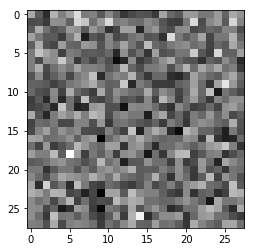

Number batches 156
0(155/156) Digit: 1.6204, gdigit: 0.1916
Epoch #1
Number batches 156
1(155/156) Digit: 1.6051, gdigit: 0.2606
Epoch #2
Supposed to be 7


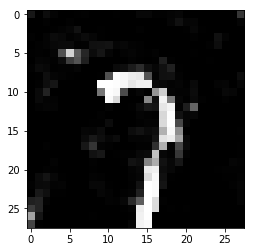

Supposed to be 2


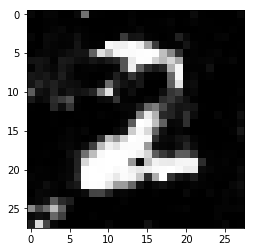

Supposed to be 1


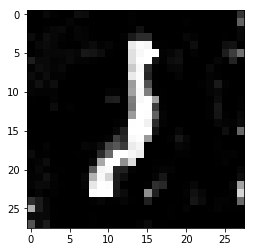

Supposed to be 3


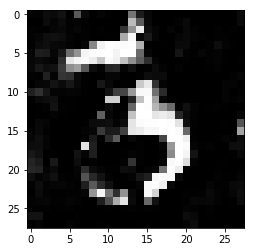

Number batches 156
2(155/156) Digit: 1.7765, gdigit: 0.1193
Epoch #3
Supposed to be 3


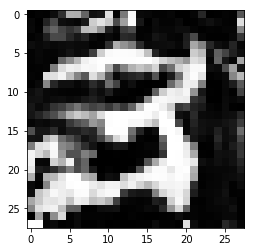

Supposed to be 6


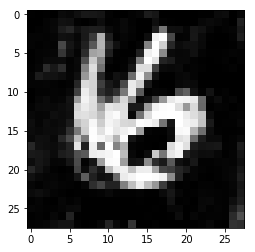

Supposed to be 7


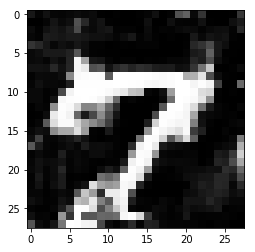

Supposed to be 8


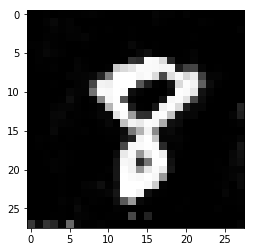

Number batches 156
3(155/156) Digit: 1.5052, gdigit: 0.2864
Epoch #4
Supposed to be 5


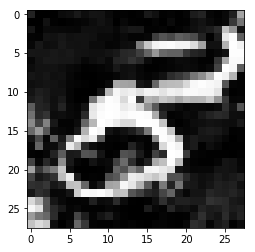

Supposed to be 5


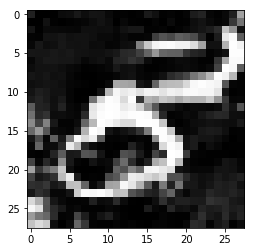

Supposed to be 1


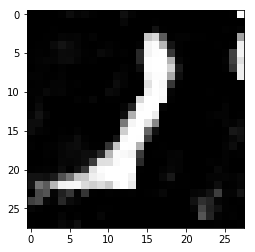

Supposed to be 2


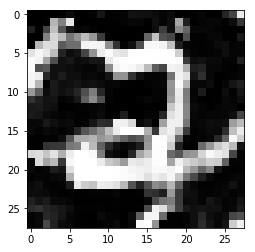

Number batches 156
4(155/156) Digit: 1.7998, gdigit: 0.2833
Epoch #5
Supposed to be 2


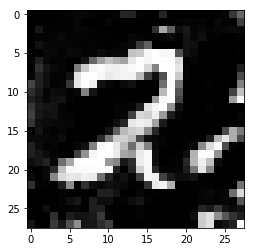

Supposed to be 1


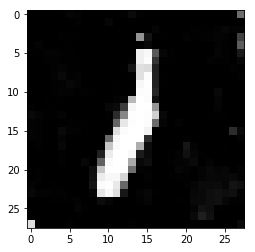

Supposed to be 6


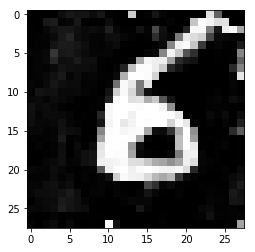

Supposed to be 2


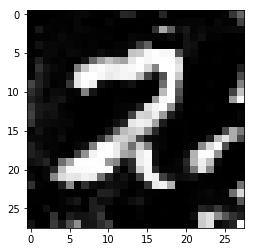

Number batches 156
5(155/156) Digit: 1.6060, gdigit: 0.1796
Epoch #6
Supposed to be 3


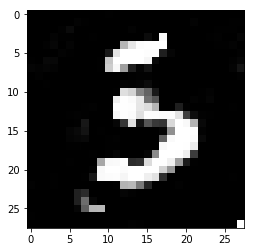

Supposed to be 0


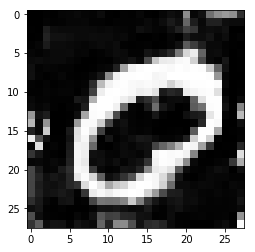

Supposed to be 5


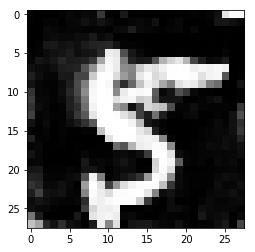

Supposed to be 3


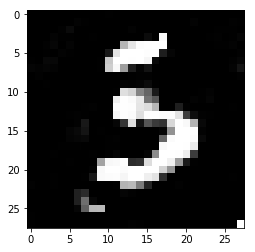

Number batches 156
6(155/156) Digit: 2.2775, gdigit: 0.1563
Epoch #7
Number batches 156
7(155/156) Digit: 1.5723, gdigit: 0.2681
Epoch #8
Supposed to be 7


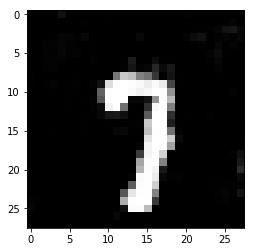

Supposed to be 5


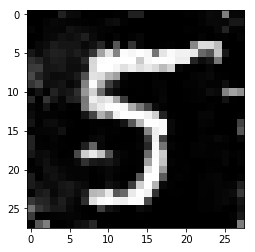

Supposed to be 6


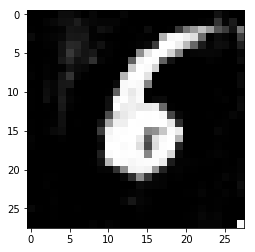

Supposed to be 5


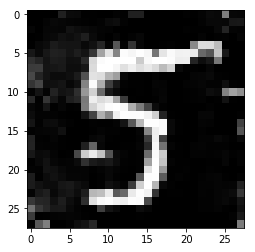

Number batches 156
8(155/156) Digit: 1.5194, gdigit: 0.2699
Epoch #9
Supposed to be 1


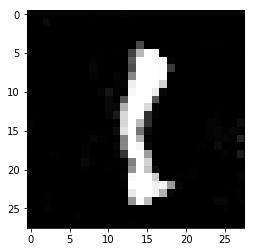

Supposed to be 0


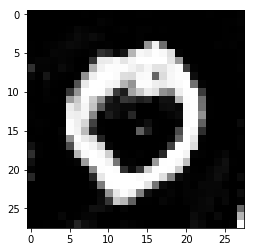

Supposed to be 6


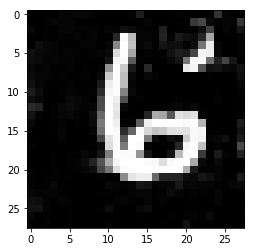

Supposed to be 8


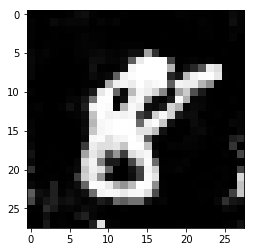

Number batches 156
9(155/156) Digit: 1.7488, gdigit: 0.1953
Epoch #10
Supposed to be 5


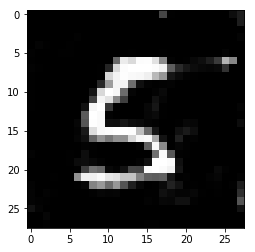

Supposed to be 5


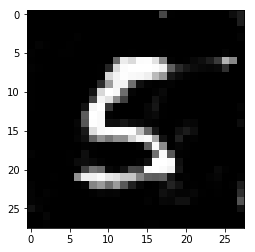

Supposed to be 8


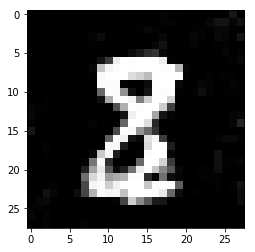

Supposed to be 1


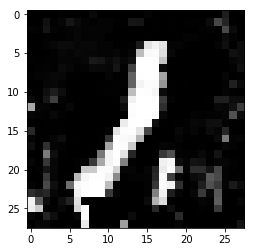

Number batches 156
10(155/156) Digit: 1.7969, gdigit: 0.1739
Epoch #11
Number batches 156
11(155/156) Digit: 1.5465, gdigit: 0.2507
Epoch #12
Supposed to be 6


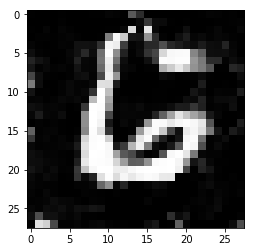

Supposed to be 5


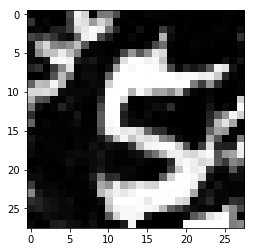

Supposed to be 0


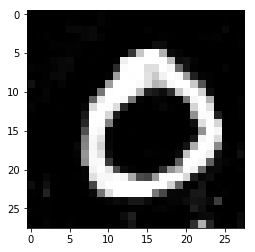

Supposed to be 5


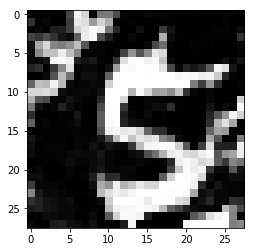

Number batches 156
12(155/156) Digit: 1.4450, gdigit: 0.2283
Epoch #13
Number batches 156
13(155/156) Digit: 1.4584, gdigit: 0.2083
Epoch #14
Number batches 156
14(155/156) Digit: 1.8434, gdigit: 0.2330
Epoch #15
Supposed to be 4


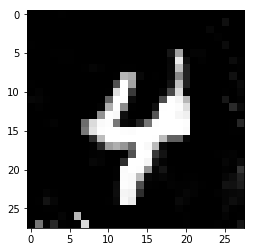

Supposed to be 8


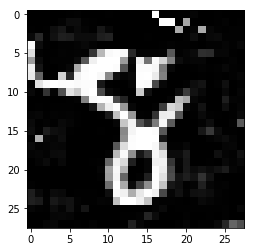

Supposed to be 1


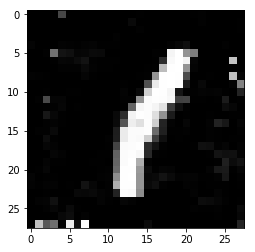

Supposed to be 8


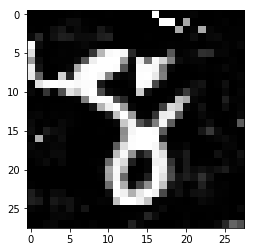

Number batches 156
15(155/156) Digit: 1.4527, gdigit: 0.2767
Epoch #16
Number batches 156
16(155/156) Digit: 1.8728, gdigit: 0.1544
Epoch #17
Number batches 156
17(155/156) Digit: 1.6384, gdigit: 0.2375
Epoch #18
Supposed to be 2


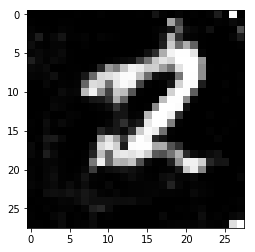

Supposed to be 8


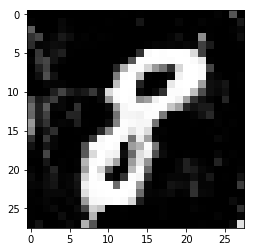

Supposed to be 4


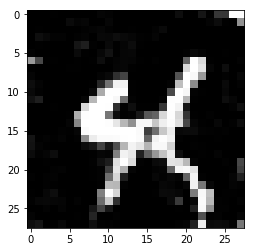

Supposed to be 6


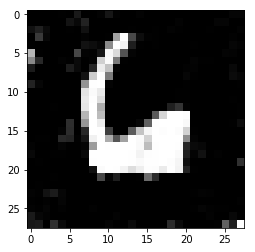

Number batches 156
18(155/156) Digit: 1.5230, gdigit: 0.2771
Epoch #19
Number batches 156
19(155/156) Digit: 1.6475, gdigit: 0.2339
Epoch #20
Supposed to be 5


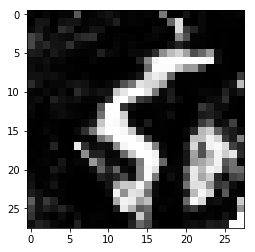

Supposed to be 5


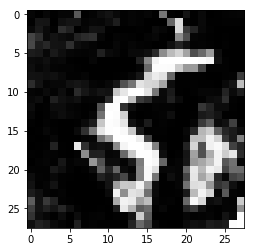

Supposed to be 5


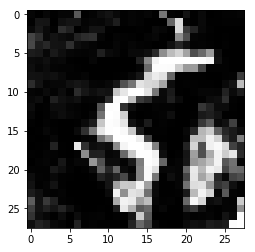

Supposed to be 5


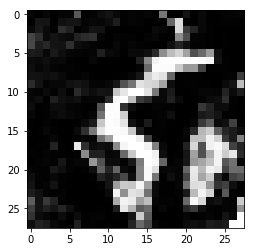

Number batches 156
20(155/156) Digit: 1.5049, gdigit: 0.2918
Epoch #21
Supposed to be 6


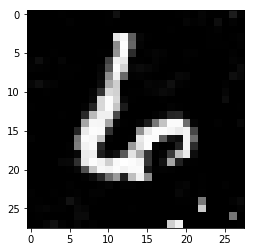

Supposed to be 0


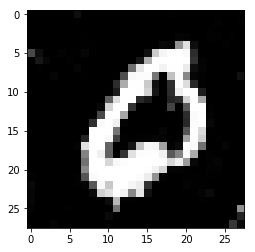

Supposed to be 0


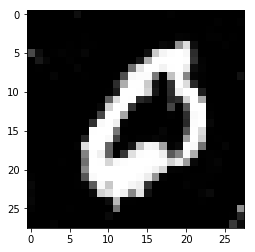

Supposed to be 8


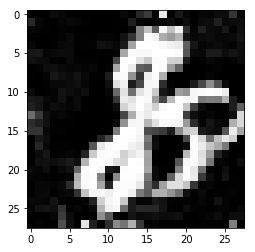

Number batches 156
21(155/156) Digit: 1.5213, gdigit: 0.1904
Epoch #22
Number batches 156
22(155/156) Digit: 1.4529, gdigit: 0.1693
Epoch #23
Number batches 156
23(155/156) Digit: 1.5275, gdigit: 0.1900
Epoch #24
Supposed to be 2


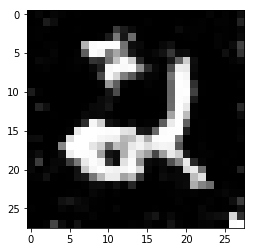

Supposed to be 5


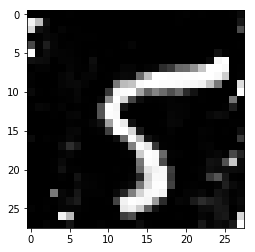

Supposed to be 5


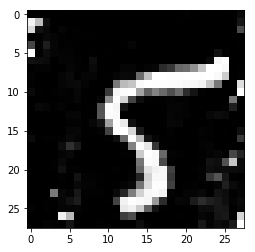

Supposed to be 0


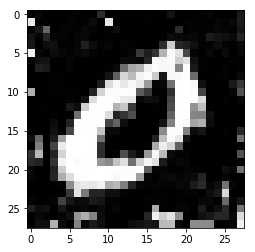

Number batches 156
24(155/156) Digit: 1.6363, gdigit: 0.1926
Epoch #25
Supposed to be 5


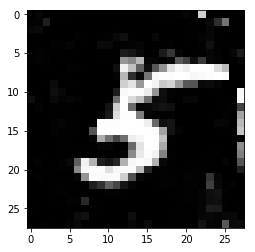

Supposed to be 2


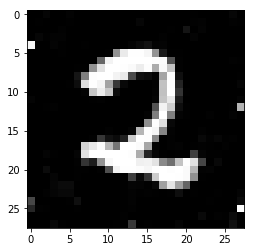

Supposed to be 1


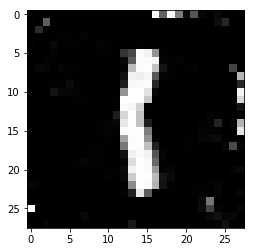

Supposed to be 4


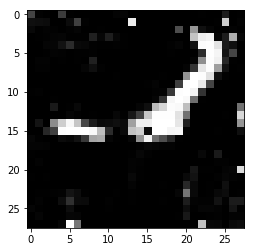

Number batches 156
25(155/156) Digit: 1.3709, gdigit: 0.2337
Epoch #26
Number batches 156
26(155/156) Digit: 1.5183, gdigit: 0.2606
Epoch #27
Supposed to be 2


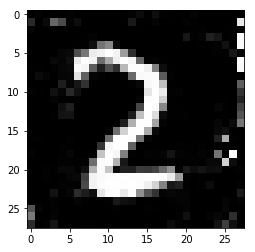

Supposed to be 4


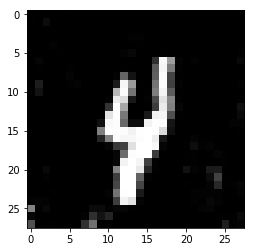

Supposed to be 4


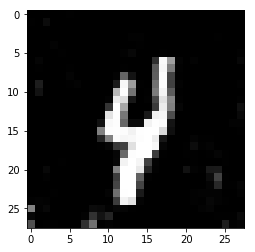

Supposed to be 1


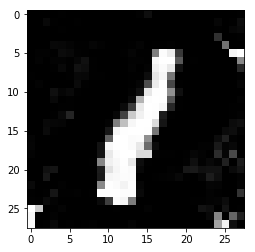

Number batches 156
27(155/156) Digit: 2.0006, gdigit: 0.3402
Epoch #28
Number batches 156
28(155/156) Digit: 2.8026, gdigit: 0.3840
Epoch #29
Number batches 156
29(155/156) Digit: 2.3462, gdigit: 0.3545
Epoch #30
Supposed to be 1


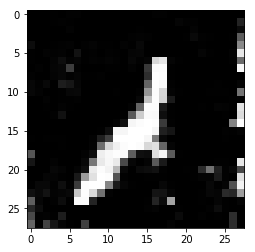

Supposed to be 4


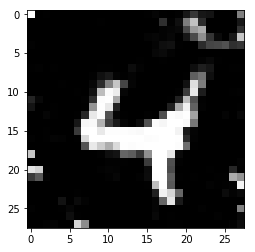

Supposed to be 8


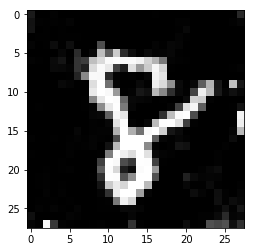

Supposed to be 0


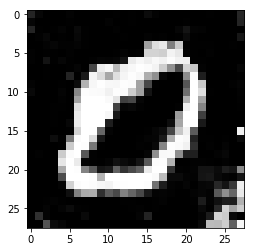

Number batches 156
30(155/156) Digit: 1.7281, gdigit: 0.3319
Epoch #31
Number batches 156
31(155/156) Digit: 1.5634, gdigit: 0.2734
Epoch #32
Number batches 156
32(155/156) Digit: 1.5937, gdigit: 0.2476
Epoch #33
Number batches 156
33(155/156) Digit: 1.8965, gdigit: 0.1586
Epoch #34
Number batches 156
34(155/156) Digit: 1.7006, gdigit: 0.1807
Epoch #35
Supposed to be 5


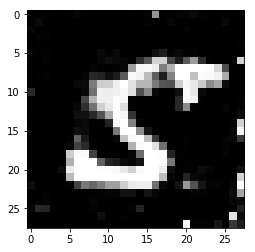

Supposed to be 2


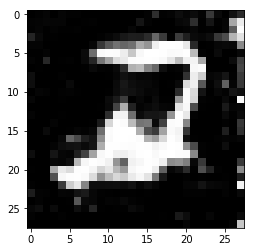

Supposed to be 1


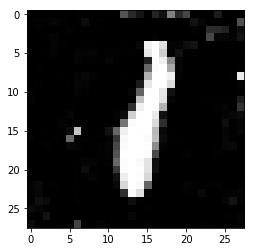

Supposed to be 8


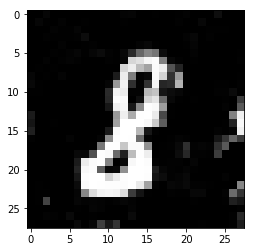

Number batches 156
35(155/156) Digit: 1.4982, gdigit: 0.2095
Epoch #36
Number batches 156
36(155/156) Digit: 1.9932, gdigit: 0.2226
Epoch #37
Number batches 156
37(155/156) Digit: 1.4746, gdigit: 0.2093
Epoch #38
Number batches 156
38(155/156) Digit: 1.5335, gdigit: 0.1728
Epoch #39
Number batches 156
39(155/156) Digit: 1.4285, gdigit: 0.2273
Epoch #40
Supposed to be 2


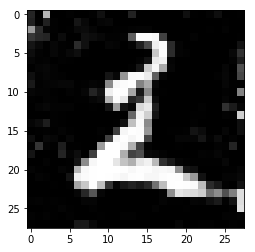

Supposed to be 0


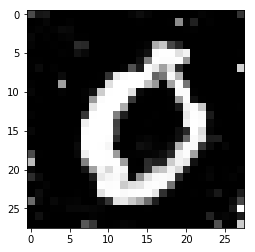

Supposed to be 2


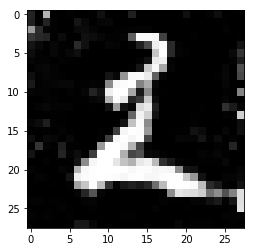

Supposed to be 4


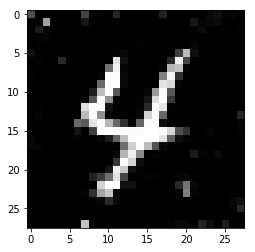

Number batches 156
40(155/156) Digit: 2.7772, gdigit: 0.2711
Epoch #41
Number batches 156
41(155/156) Digit: 1.6211, gdigit: 0.2109
Epoch #42
Number batches 156
42(155/156) Digit: 1.5422, gdigit: 0.2181
Epoch #43
Number batches 156
43(155/156) Digit: 1.8710, gdigit: 0.0826
Epoch #44
Number batches 156
44(155/156) Digit: 1.6020, gdigit: 0.2086
Epoch #45
Supposed to be 4


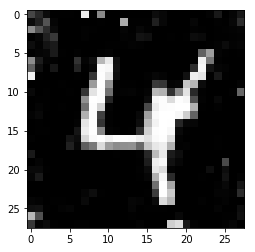

Supposed to be 4


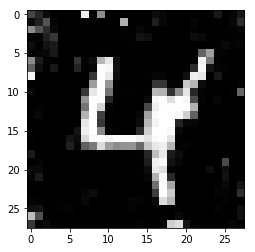

Supposed to be 4


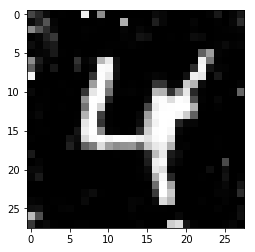

Supposed to be 6


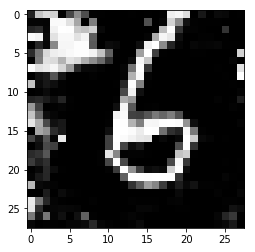

Number batches 156
45(155/156) Digit: 1.5712, gdigit: 0.2341
Epoch #46
Number batches 156
46(155/156) Digit: 1.6077, gdigit: 0.1848
Epoch #47
Number batches 156
47(155/156) Digit: 1.8069, gdigit: 0.2284
Epoch #48
Number batches 156
48(155/156) Digit: 1.6192, gdigit: 0.1477
Epoch #49
Number batches 156
49(155/156) Digit: 1.6602, gdigit: 0.1438


In [13]:
# Keep this. 
print(y_train)
batch_size = 128
print("Starting regression...")
target_y = target_y(y_train)
for epoch in range(50): #50 epochs
    print('Epoch #%d' % epoch)
    
    if epoch < 10 and epoch % 2 == 0:
        # In some cases display Generate 4 images and display them.
        disp_sample(g)
    elif epoch < 30 and epoch % 3 == 0:
        disp_sample(g)
            
    elif epoch % 5 == 0:
        disp_sample(g)
    
    num_batches = int(x_train.shape[0] / batch_size)
    print('Number batches %i' % num_batches)
    for i in range(num_batches):
        #######################################################
        #TODO: Complete a training iteration
        # Generate noise.
        noise = get_noise(batch_size, NOISE_DIM)

        # Generate images from the noise using the generator.
        generated_images = g.predict(noise, verbose=0)
        
        # Grab the image batch for this iteration. 
        real_images = x_train[i * batch_size: (i+1) * batch_size]
        real_images = real_images.reshape((-1, 28, 28, 1))
        y_vals = y_train_cat[i * batch_size : (i+1) * batch_size]
        y_target = target_y[i * batch_size : (i+1) * batch_size]
        
        # Train the discriminator using the generated images and the real images.
        # Contains the real and fake images. real then fake
        
        X = np.concatenate([generated_images, real_images])
            
        # Labels if the sample is real (1) or not real (0). 
        
        y = np.concatenate([y_target, y_vals])
        
        # Remember that the discriminator has to have d.trainable = True!
        d.trainable = True
        digit.trainable = True 
        #d_loss = d.train_on_batch(X, y)
        
        #Train the digit recognizer with real_images
        digit_loss = digit.train_on_batch(X, y)
        

        # Generate more noise to feed into the full gan network to train the generative portion. 
        noise = get_noise(batch_size, NOISE_DIM)
        
        d.trainable = False
        digit.trainable = False
        
        # Get the g_loss (fill in the ... part between the parantheses)
        #g_loss = gd.train_on_batch(noise, np.ones(noise.shape[0]))

        # Try to get the generator to generate images similar to what the seed should be
        gdigit_loss = gdigit.train_on_batch(noise, noise) 
    
    print('%i(%i/%i) Digit: %.4f, gdigit: %.4f' % (
                    epoch, i, num_batches, digit_loss, gdigit_loss))
        #######################################################

#########################################################################################
# Why is my generative loss oscillating???   
# Don't worry this is normal as the generator is oscillating between possible solutions
#########################################################################################
        

In [32]:
def disp_all_digits(g):
    #Put noise between 0 and .5 so that not very likely to be most digits, with one above this amount
    noise = np.random.uniform(0, .005, size=(batch_size, NOISE_DIM))
    i = 0
    while i < 20:
        noise[i][i] += .995
        i += 1
    generated_images = g.predict(noise, verbose=0)
    
    print("Digits generated from 0 - 4")
    i = 0
    while i < 5:
        #Print what it's 'supposed' to look like
        plt.imshow(generated_images[i].reshape((28, 28)), cmap=plt.get_cmap('gray'))
        plt.show()
        i += 1
        
    print ("Digits generated from 4 - 9")
    
    while i < 10:
        plt.imshow(generated_images[i].reshape((28, 28)), cmap=plt.get_cmap('gray'))
        plt.show()
        i += 1
    

Digits generated from 0 - 4


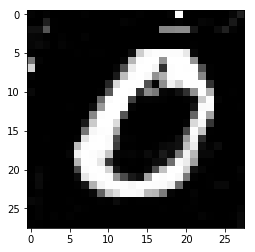

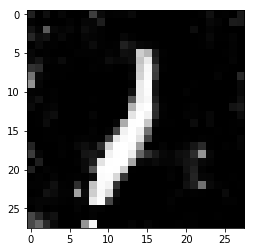

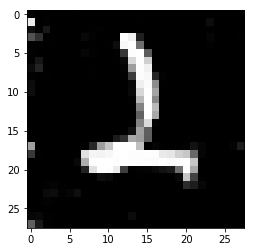

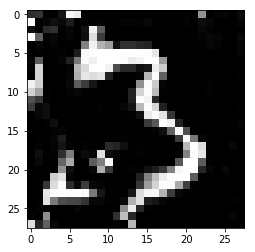

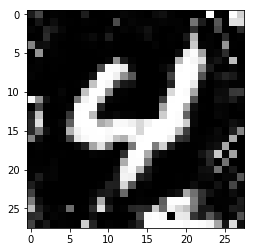

Digits generated from 4 - 9


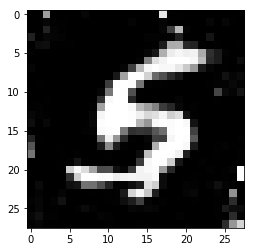

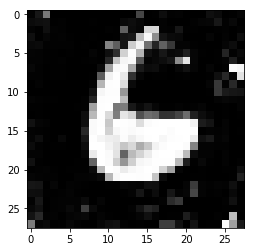

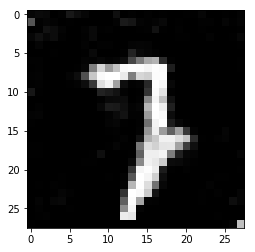

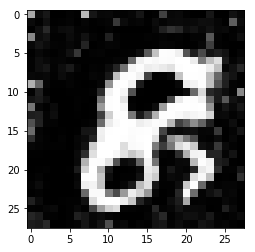

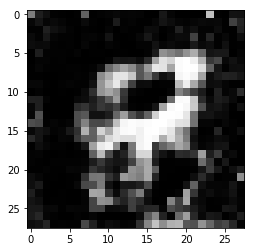

In [33]:
disp_all_digits(g)


In [ ]:
#That 9 is awful!
